# 02. Neural Network Classification with PyTorch


Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

Book version of this notebook - https://www.learnpytorch.io/02_pytorch_classification/

All other resources - https://github.com/mrdbourke/pytorch-deep-learning

Stuck? Ask a question - https://github.com/mrdbourke/

## 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [5]:
type(X)

numpy.ndarray

In [6]:
# Make DataFrame of circle data
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


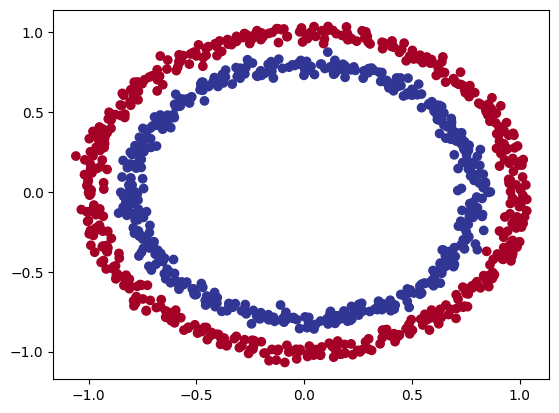

In [7]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

**Note:** The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment  but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
# View the first example ofo features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sampel of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sampel of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [10]:
import torch
torch.__version__

'2.2.1+cu121'

In [11]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [12]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # FYI: default float type is float32
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [26]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                     y,
                                                     test_size=0.2, # 0.2 = 20% of data will be test & 80% will be train
                                                     random_state=42)

In [27]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify out blue and red dots.

To do so, we want to :
1. Setup device agnostic code so out code will run an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define loss function and Optimizer
4. Create a training and test loop

In [16]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic code, let's create a model that:

1. Subclass `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instatiate an instace of our model class and send it to the target `device`

In [17]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

    # self.two_linear_layers = nn.Sequential(
    #     nn.Linear(in_features=2, out_features=5),
    #     nn.Linear(in_features=5, out_features=1)
    #)
  #3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
    #return self.two_linear_layers(x)


# 4. Instantiate an instance of out model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
device

'cuda'

In [19]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [20]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0670, -0.0936],
                      [ 0.5325, -0.1226],
                      [-0.4558,  0.0665],
                      [ 0.4437,  0.6103],
                      [ 0.4179, -0.3529]], device='cuda:0')),
             ('0.bias',
              tensor([-0.4061,  0.2818,  0.0619,  0.0720, -0.5659], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.2847,  0.1776, -0.1414, -0.1285,  0.4404]], device='cuda:0')),
             ('1.bias', tensor([0.1370], device='cuda:0'))])

In [22]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-1.],
        [-0.],
        [-0.],
        [-1.],
        [ 0.],
        [ 0.],
        [-0.],
        [ 0.],
        [-0.],
        [-0.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [23]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example for regression you might want...
  * MAE (Mean Absolute Error)
  * MSE (Mean Squared Error)

For classification you might want...
  * Binary Cross Entropy
  * Categorical Cross Entropy (a.k.a. Cross Entropy)


As a reminder, the loss function measures how *wrong* your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built in options

* For some common choices of loss functions and optimizers - https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer

* For the loss function we're going to use `torch.nn.BECWithLogitsLoss()`, for more on what binary cross entropy (BCE) is, check out this article -  https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

* For a definitions on what a logit is in deep learning - https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow/52111173#52111173

* For different optimizers see `torch.optim`

In [24]:
# Setup the loss function
#losss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
# nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss()
# )
# BCEWithLogitsLoss has better numerical stability than just combining Sigmoid and BCE Loss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [25]:
# Calculate accuracy - out of 100 examples, what percentage does out model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## 3. Train model

To train our model, we're going to need to builid a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

## 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [30]:
X_test.shape

torch.Size([200, 2])

In [31]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.5094],
        [-0.4711],
        [-0.3184],
        [-0.5647],
        [ 0.1439]], device='cuda:0')

In [67]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [68]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs


tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [69]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

In [70]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [71]:
### 3.2 Building a training and testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):

  # Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  #loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
  #               y_train)

  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input

  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ###  Testing
  model_0.eval()

  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)

    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)


  # Print out what's happenin'
  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.69796 | Acc: 51.88% | Test loss: 0.69440, Test acc: 58.00%
Epoch: 10 | Loss: 0.69590 | Acc: 51.25% | Test loss: 0.69305, Test acc: 53.00%
Epoch: 20 | Loss: 0.69490 | Acc: 51.62% | Test loss: 0.69254, Test acc: 49.50%
Epoch: 30 | Loss: 0.69435 | Acc: 51.12% | Test loss: 0.69236, Test acc: 49.50%
Epoch: 40 | Loss: 0.69401 | Acc: 50.88% | Test loss: 0.69232, Test acc: 51.00%
Epoch: 50 | Loss: 0.69378 | Acc: 50.25% | Test loss: 0.69234, Test acc: 50.00%
Epoch: 60 | Loss: 0.69362 | Acc: 50.00% | Test loss: 0.69239, Test acc: 51.50%
Epoch: 70 | Loss: 0.69351 | Acc: 50.25% | Test loss: 0.69246, Test acc: 51.00%
Epoch: 80 | Loss: 0.69342 | Acc: 49.88% | Test loss: 0.69254, Test acc: 50.00%
Epoch: 90 | Loss: 0.69336 | Acc: 49.88% | Test loss: 0.69262, Test acc: 53.00%
Epoch: 100 | Loss: 0.69331 | Acc: 49.25% | Test loss: 0.69271, Test acc: 53.00%
Epoch: 110 | Loss: 0.69327 | Acc: 49.75% | Test loss: 0.69279, Test acc: 54.00%
Epoch: 120 | Loss: 0.69324 | Acc: 50.25% | Test los

In [72]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and visualize them!

In orther words, "Visualize, visualize, visualize!"

To do so, we're going to import a function called `plot_decision boundary()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [73]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


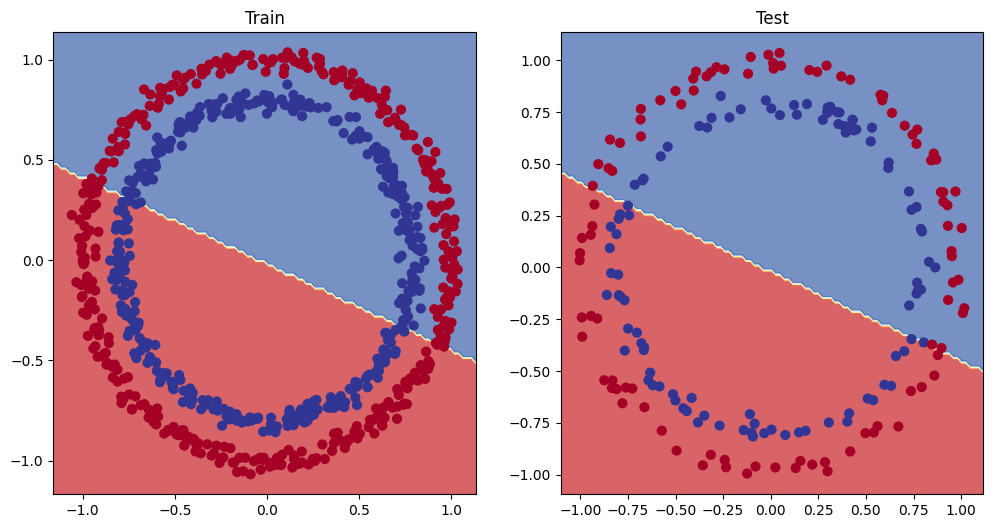

In [74]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn abou the patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Chanding the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning enigineers and data scientists) can change they are referred to as **hyperparameters**.

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [75]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)


  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [76]:
# Create a loss function
loss_fn_2 = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer_2 = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [82]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  # Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate the loss/accuracy
  loss = loss_fn_2(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input

  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer_2.zero_grad()

  # 4. Loss backwards (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer_2.step()

  # Testing
  model_1.eval()

  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Caculate test loss/acc
    test_loss = loss_fn_2(test_logits,
                          y_test)

    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happenin'
    if epoch % 10 == 0:
      print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')


Epoch: 0 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 10 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 20 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 30 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 40 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 50 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 60 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 70 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 80 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 90 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 110 | Loss: 0.69396 | Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 120 | Loss: 0.69396 | Acc: 50.88% | Test los

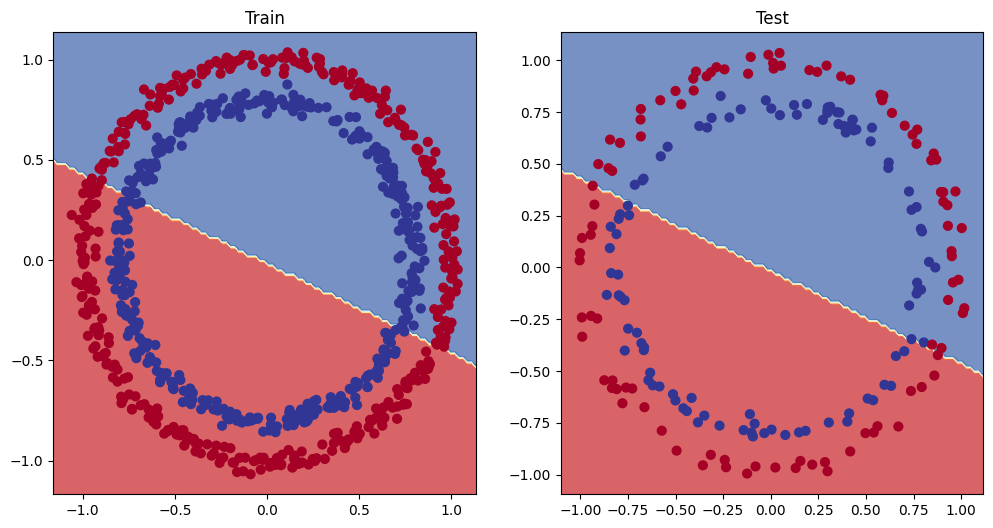

In [78]:
# Plot the decision boundary
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to test our a smaller problem.

In [87]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regressoin = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check data
print(len(X_regression))
X_regression[:5], y_regressoin[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [90]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))

X_train_regression, y_train_regression = X_regression[:train_split], y_regressoin[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regressoin[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

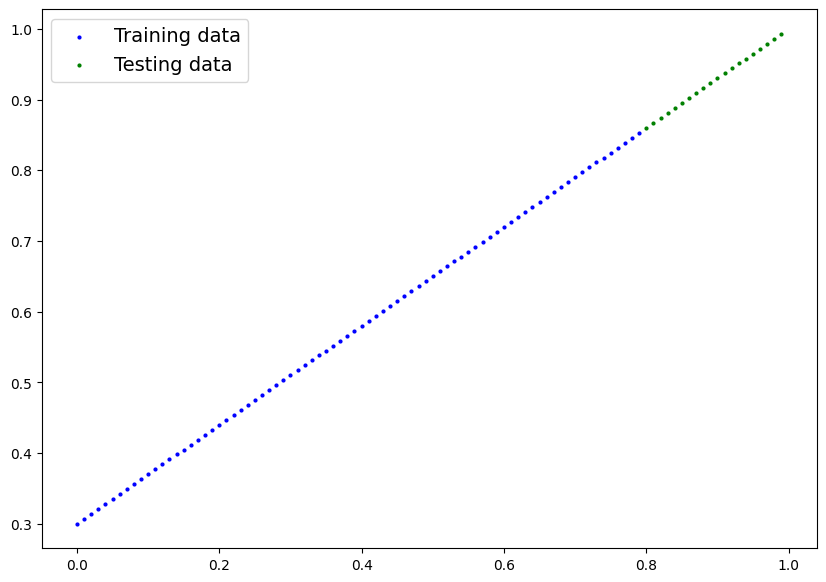

In [91]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

#### 5.2 Adjusting `model_1` to fit a straight line

In [95]:
# Same architecture as model_1 (but using nn.Sequential)

model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [101]:
# Loss and optimizer
linear_loss_fn = nn.L1Loss() # MAE
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01) # Stochastic Gradiant Descent

In [102]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):

  model_2.train()

  y_pred = model_2(X_train_regression)

  loss = linear_loss_fn(y_pred, y_train_regression)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  # Testing
  model_2.eval()

  with torch.inference_mode():
    test_pred = model_2(X_test_regression)

    test_loss = linear_loss_fn(test_pred, y_test_regression)

    if epoch % 100 == 0:
      print(f'Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}')

Epoch: 0 | Loss: 0.06466 | Test loss: 0.12597
Epoch: 100 | Loss: 0.00743 | Test loss: 0.00093
Epoch: 200 | Loss: 0.00621 | Test loss: 0.00123
Epoch: 300 | Loss: 0.00619 | Test loss: 0.00116
Epoch: 400 | Loss: 0.00617 | Test loss: 0.00094
Epoch: 500 | Loss: 0.00646 | Test loss: 0.00138
Epoch: 600 | Loss: 0.00614 | Test loss: 0.00110
Epoch: 700 | Loss: 0.00612 | Test loss: 0.00103
Epoch: 800 | Loss: 0.00641 | Test loss: 0.00149
Epoch: 900 | Loss: 0.00639 | Test loss: 0.00118


In [108]:
# Turn on evaluation mode
model_2.eval()

# Make Predictions
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

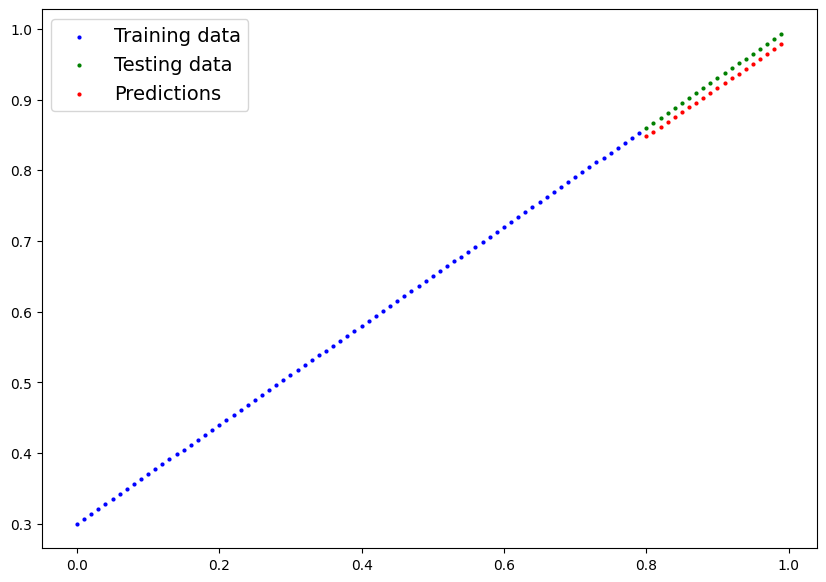

In [109]:
# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

### 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

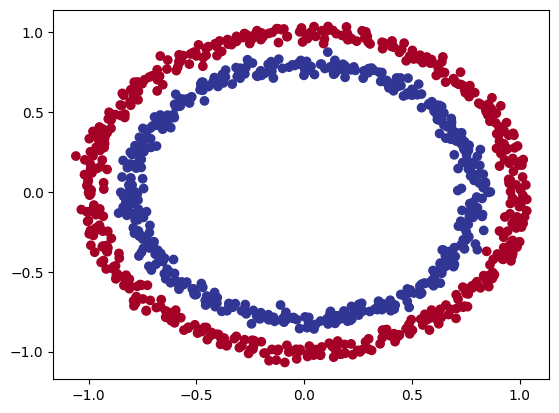

In [131]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [132]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Builing a model with non-linearity

* Linear = straight linear
* Non-linear = non-staight lines

Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.

In [133]:
# Build a model with non-linear activation functions
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x):
    # Where should we put our non-linear activation functions?
    return self.layer_3(
        self.relu(
            self.layer_2(
                self.relu(
                    self.layer_1(x)
                )
            )
        )
    )

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [134]:
# Setup loss and optimizer

# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linerity

In [135]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# set epochs
epochs = 2000

# Loop through data
for epoch in range(epochs):

  # Set training mode
  model_3.train()

  # Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # Calculate the loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backwards (backpropagation)
  loss.backward()

  # Optimizer step (gradient descent)
  optimizer.step()

  # Set evaluation mode
  model_3.eval()

  with torch.inference_mode():
    # forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happenin'
    if epoch % 100 == 0:
      print(f'Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%')


Epoch: 0 | Loss: 0.6929 | Acc: 50.00% | Test Loss: 0.6932, Test acc: 50.00%
Epoch: 100 | Loss: 0.6912 | Acc: 52.88% | Test Loss: 0.6910, Test acc: 52.50%
Epoch: 200 | Loss: 0.6898 | Acc: 53.37% | Test Loss: 0.6894, Test acc: 55.00%
Epoch: 300 | Loss: 0.6879 | Acc: 53.00% | Test Loss: 0.6872, Test acc: 56.00%
Epoch: 400 | Loss: 0.6852 | Acc: 52.75% | Test Loss: 0.6841, Test acc: 56.50%
Epoch: 500 | Loss: 0.6810 | Acc: 52.75% | Test Loss: 0.6794, Test acc: 56.50%
Epoch: 600 | Loss: 0.6751 | Acc: 54.50% | Test Loss: 0.6729, Test acc: 56.00%
Epoch: 700 | Loss: 0.6666 | Acc: 58.38% | Test Loss: 0.6632, Test acc: 59.00%
Epoch: 800 | Loss: 0.6516 | Acc: 64.00% | Test Loss: 0.6476, Test acc: 67.50%
Epoch: 900 | Loss: 0.6236 | Acc: 74.00% | Test Loss: 0.6215, Test acc: 79.00%
Epoch: 1000 | Loss: 0.5682 | Acc: 87.75% | Test Loss: 0.5738, Test acc: 86.50%
Epoch: 1100 | Loss: 0.4815 | Acc: 93.50% | Test Loss: 0.4993, Test acc: 90.50%
Epoch: 1200 | Loss: 0.3706 | Acc: 97.75% | Test Loss: 0.4059, Te

## 6.4 Evaluating a model trained with non-linear activation functions

In [136]:
# Makes predictions
model_3.eval()

with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

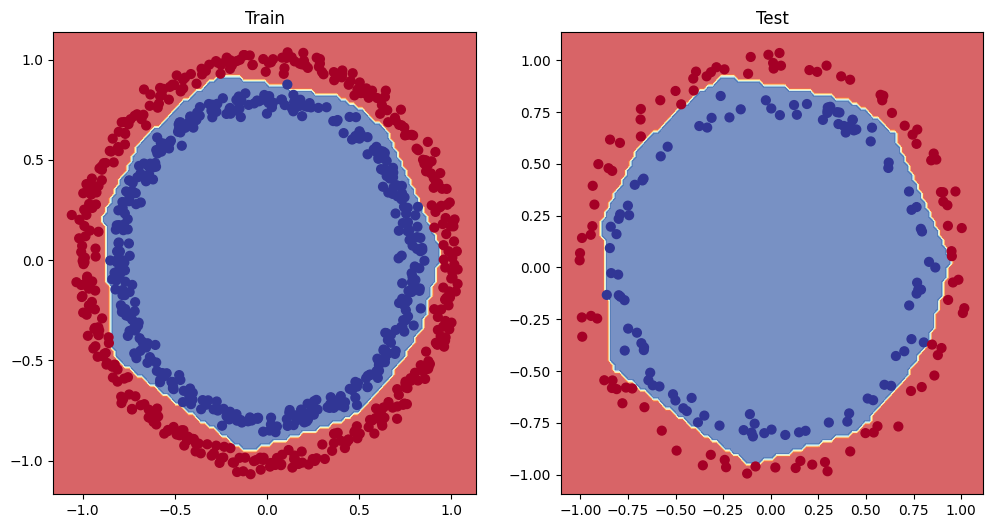

In [138]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # number or rows, number of columns, index where plot appears
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train) # model_1 = no non-linearity
#plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear & non-linear functions.

In [139]:
# Create a tensor
A = torch.arange (-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [142]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

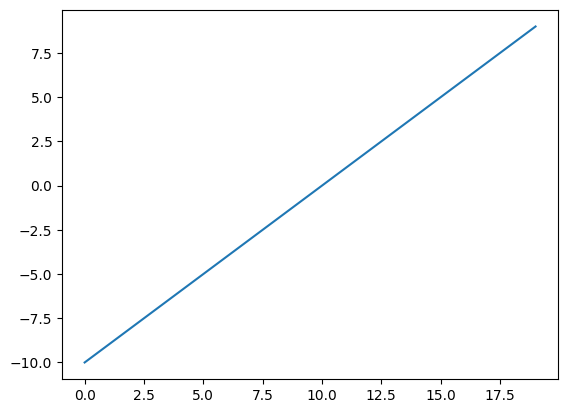

In [141]:
# Visualize the tensor
plt.plot(A);

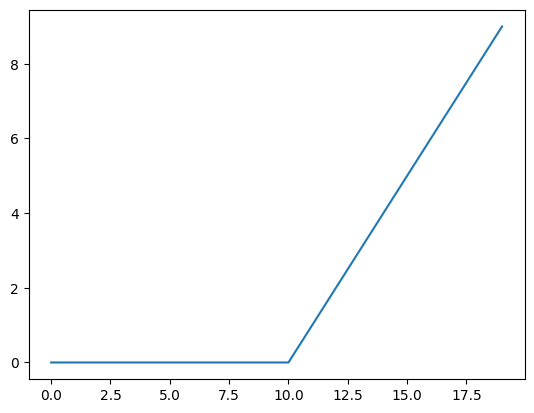

In [144]:
plt.plot(torch.relu(A));

In [147]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

Relu -

![](https://drive.google.com/uc?export=view&id=1mJfCODIed4Ys0gxLVgz8Ac6lx5hACTtm)  


In [146]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

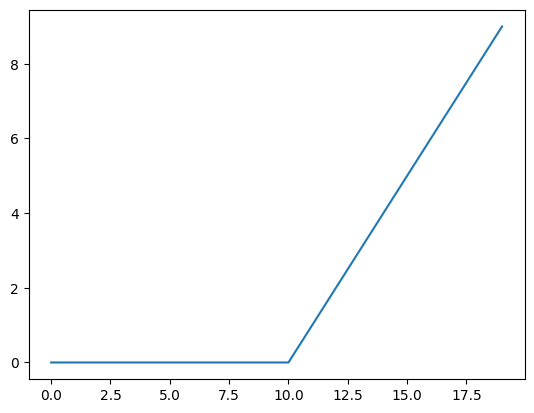

In [148]:
# Plot ReLu Activation function
plt.plot(relu(A));

Sigmoid -

![](https://drive.google.com/uc?export=view&id=1lg66O9yeDWuMHN638ezACFnCMPxsbHxg)  


In [150]:
# Now let's do the same for Sigmoid
def sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1 / (1 + torch.exp(-x))

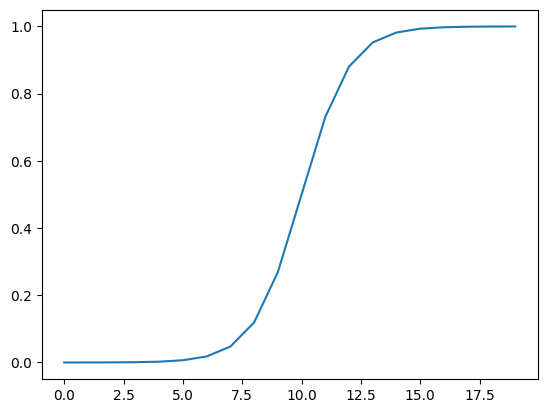

In [152]:
plt.plot(torch.sigmoid(A));

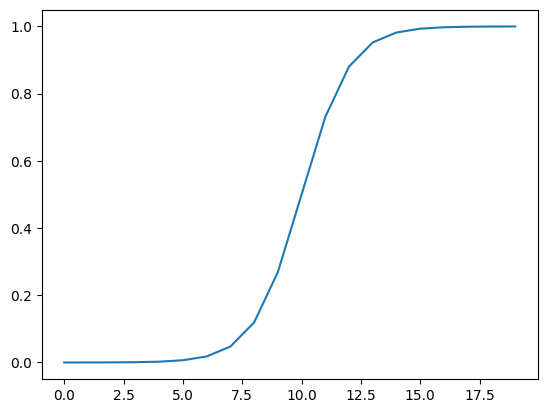

In [153]:
plt.plot(sigmoid(A));

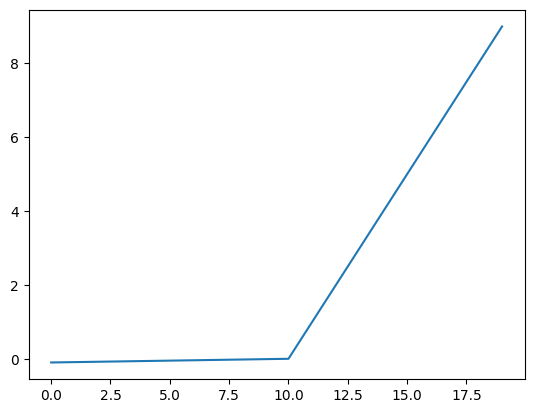

In [168]:
m = nn.LeakyReLU()
plt.plot(m(A));

In [169]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

In [170]:
m(A)

tensor([-0.1000, -0.0900, -0.0800, -0.0700, -0.0600, -0.0500, -0.0400, -0.0300,
        -0.0200, -0.0100,  0.0000,  1.0000,  2.0000,  3.0000,  4.0000,  5.0000,
         6.0000,  7.0000,  8.0000,  9.0000])

## 8. Putting is all together with a multi-class classification problem

* Binary classification = one this or another (cat vs. do, spam vs. not spam, fraud vs. no fraud)
* Multi-class classification = more than one thing or anoter (cat vs. dog vs. chicken)

### 8. Creating a toy multi-class dataset

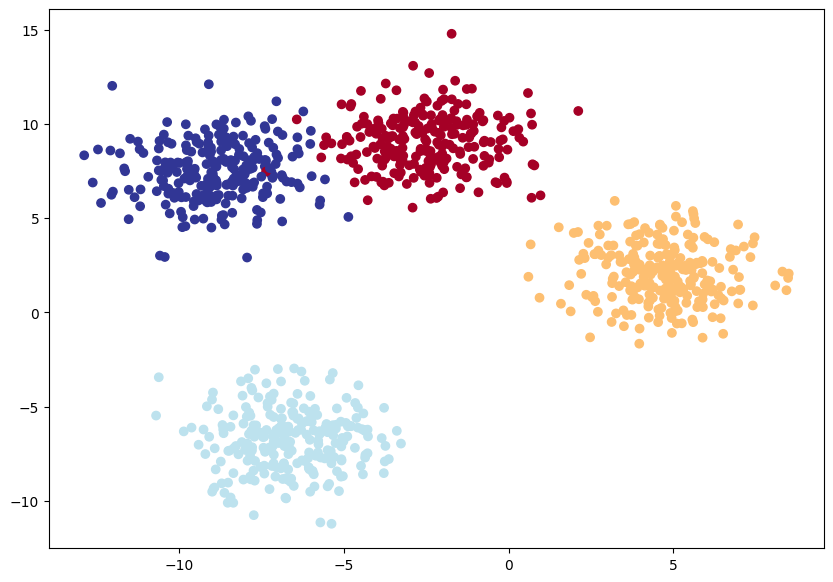

In [231]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_SAMPLES = 1000
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=NUM_SAMPLES,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

#4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);



### 8.2 Building a multi-class classification model in PyTorch

In [209]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [232]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    '''
    Initialized multi-class classification model

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of output features (or classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:
      Model with layers and forward method implemented

    Example:
      model = BlobModel(input_features=2, output_features=4)
      print(model)
    '''
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [174]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [175]:
torch.unique(y_blob_train)

tensor([0., 1., 2., 3.])

### 8.3 Create a loss function and an optimizer for a multi-class classificaiton model

In [233]:
# Create a loss function for multi-class classification - loss function measures how wrong our model's predictions are
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class optimization - optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1) # learning rate is a hyperparameter you can change

### 8.4 Getting prediction probablities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's output (logits) to prediction probabilities and then to prediction labels.

Logits (raw outputs of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilities)

In [194]:
# Let's get some raw ouputs of our model (logits)
model_4.eval()

with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.2508,  0.1497,  0.2770, -0.3459],
        [-0.3547, -0.0455,  1.0306, -0.8957],
        [-0.2283,  0.1471,  0.2902, -0.3109],
        [-0.2948,  0.0942,  0.3700, -0.3349],
        [-0.4660, -0.2790,  0.9423, -0.7431],
        [-0.3712, -0.0656,  1.1652, -0.9934],
        [-0.1879,  0.1704,  0.3583, -0.2697],
        [-0.4417, -0.3071,  0.9779, -0.8048],
        [-0.2519,  0.1476,  0.2767, -0.3448],
        [-0.4464, -0.2865,  0.9511, -0.7734]], device='cuda:0')

In [193]:
y_blob_test[:10]

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.])

In [195]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.2508,  0.1497,  0.2770, -0.3459],
        [-0.3547, -0.0455,  1.0306, -0.8957],
        [-0.2283,  0.1471,  0.2902, -0.3109],
        [-0.2948,  0.0942,  0.3700, -0.3349],
        [-0.4660, -0.2790,  0.9423, -0.7431]], device='cuda:0')
tensor([[0.1962, 0.2928, 0.3326, 0.1784],
        [0.1441, 0.1963, 0.5758, 0.0839],
        [0.1978, 0.2879, 0.3322, 0.1821],
        [0.1859, 0.2742, 0.3613, 0.1786],
        [0.1418, 0.1709, 0.5798, 0.1075]], device='cuda:0')


In [197]:
y_pred_probs[0].sum() # softmax means that are in range of 0 ->1 and all sum up to 1

tensor(1., device='cuda:0')

In [198]:
y_pred_probs[0].max()

tensor(0.3326, device='cuda:0')

In [199]:
y_pred_probs[0].argmax()

tensor(2, device='cuda:0')

In [200]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')

In [201]:
y_blob_test

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0., 0., 1., 0., 0., 0., 3., 3., 2.,
        3., 3., 3., 0., 1., 2., 2., 2., 3., 0., 1., 0., 3., 1., 1., 3., 1., 2.,
        1., 3., 0., 2., 0., 3., 3., 2., 0., 3., 1., 1., 0., 3., 1., 0., 1., 1.,
        3., 2., 1., 1., 3., 2., 2., 0., 3., 2., 2., 0., 0., 3., 3., 0., 0., 3.,
        3., 3., 2., 3., 3., 3., 3., 1., 0., 2., 3., 2., 3., 3., 2., 3., 3., 2.,
        3., 3., 1., 3., 3., 3., 1., 0., 3., 2., 0., 0., 3., 0., 2., 3., 1., 0.,
        3., 2., 1., 1., 0., 2., 2., 3., 0., 0., 1., 2., 2., 3., 0., 1., 2., 0.,
        0., 0., 2., 3., 1., 2., 3., 2., 0., 3., 0., 0., 1., 1., 1., 0., 2., 2.,
        2., 2., 0., 3., 3., 2., 2., 1., 3., 2., 0., 0., 3., 3., 2., 1., 2., 0.,
        3., 2., 0., 3., 2., 0., 2., 2., 2., 0., 3., 1., 1., 1., 1., 1., 3., 1.,
        0., 2., 2., 1., 2., 2., 0., 1., 2., 2., 0., 0., 1., 3., 2., 0., 3., 1.,
        2., 1.])

In [187]:
next(model_4.parameters()).device

device(type='cuda', index=0)

In [188]:
X_blob_test.device

device(type='cpu')

### 8.5 Create a training loop and testing loop for a multi-class PyTorch model

In [234]:
# Fit the multi-class model to the data

# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# set epochs
epochs = 100

# loop through data
for epoch in range(epochs):

  # set training mode
  model_4.train()

  # forward pass
  y_logits = model_4(X_blob_train).squeeze()
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # calculate the loss/accuracy
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backwars (backpropagation)
  loss.backward()

  # Optimizer step (gradient descent)
  optimizer.step()

  # Set evaluation mode
  model_4.eval()

  with torch.inference_mode():
    # forward pass
    test_logits = model_4(X_blob_test).squeeze()
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    # calculate test loss/acc
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    # print out what's happenin'
    if epoch % 10 == 0:
      print(f'Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%')



Epoch: 0 | Loss: 1.1588 | Acc: 40.38% | Test Loss: 1.0755 | Test acc: 48.00%
Epoch: 10 | Loss: 0.6448 | Acc: 96.75% | Test Loss: 0.6607 | Test acc: 97.50%
Epoch: 20 | Loss: 0.4254 | Acc: 98.50% | Test Loss: 0.4307 | Test acc: 100.00%
Epoch: 30 | Loss: 0.2529 | Acc: 99.12% | Test Loss: 0.2451 | Test acc: 99.50%
Epoch: 40 | Loss: 0.1123 | Acc: 99.25% | Test Loss: 0.1023 | Test acc: 99.50%
Epoch: 50 | Loss: 0.0663 | Acc: 99.25% | Test Loss: 0.0585 | Test acc: 99.50%
Epoch: 60 | Loss: 0.0507 | Acc: 99.25% | Test Loss: 0.0429 | Test acc: 99.50%
Epoch: 70 | Loss: 0.0430 | Acc: 99.25% | Test Loss: 0.0349 | Test acc: 99.50%
Epoch: 80 | Loss: 0.0384 | Acc: 99.25% | Test Loss: 0.0299 | Test acc: 99.50%
Epoch: 90 | Loss: 0.0352 | Acc: 99.25% | Test Loss: 0.0266 | Test acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [235]:
# make predictions
model_4.eval()

with torch.inference_mode():
  y_logits = model_4(X_blob_test)
  y_pred_probs = torch.softmax(y_logits, dim=1).argmax(dim=1)

y_blob_test[:10], y_pred_probs[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'))

**Without** Linear Function Relu

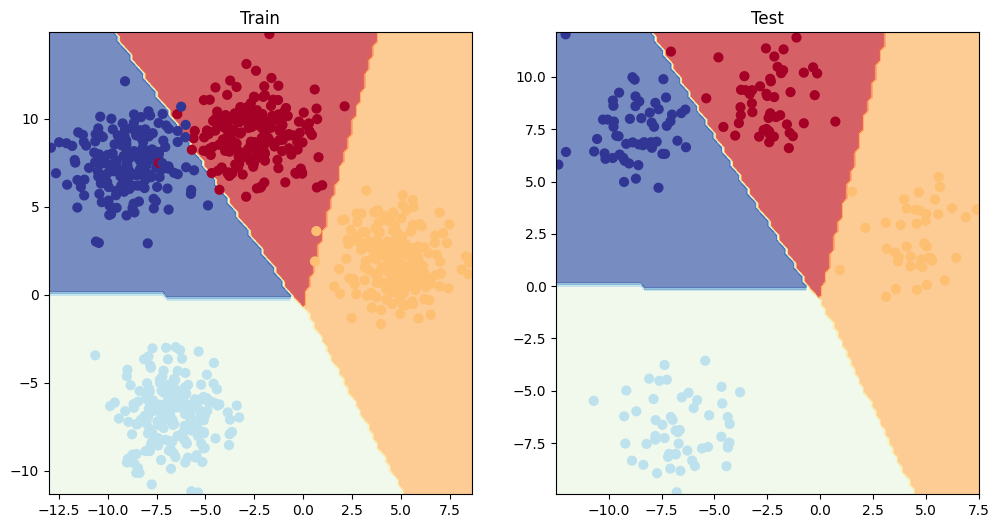

In [230]:
# plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_pred_probs)


**With**  Linear Function Relu

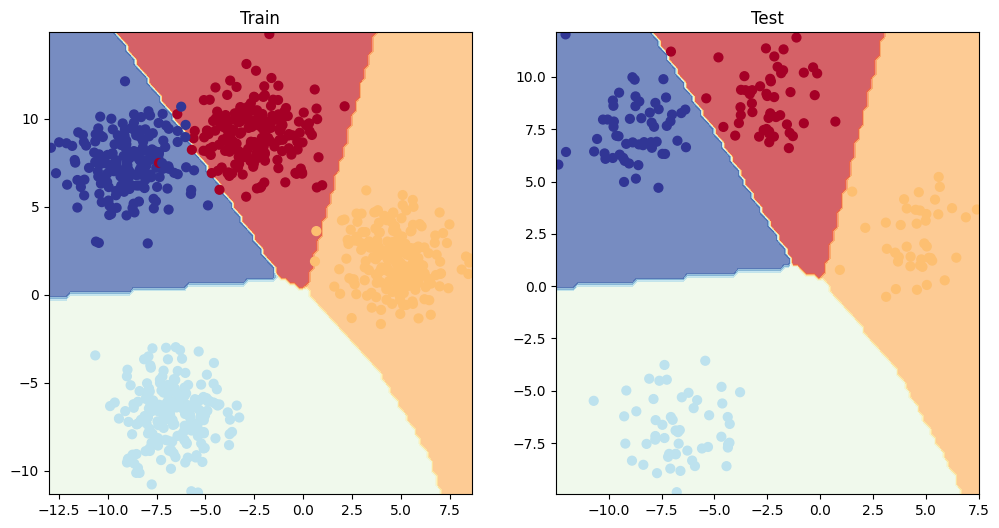

In [236]:
# plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_pred_probs)


## 9. A few more classification metrics.... (to evaluate our classification model)

* Accuracy - out of 100 samples, how many does our model get right? Good to use when you have balanced classes.
* Precision
* Recall
* F1-score
* Confusion matrix
* Classfication report

See this article for when to use precision/recall - https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

If you want access lot of PyTorch metrics, see TorchMetrics - https://lightning.ai/docs/torchmetrics/stable/


In [238]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 10.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [242]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accracy
torchmetric_accuracy(y_pred_probs, y_blob_test)

tensor(0.9950, device='cuda:0')

In [243]:
torchmetric_accuracy.device

device(type='cuda', index=0)